In [1]:
# read disney_plus_reviews.csv into a DataFrame
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, Sequential
from scipy.sparse import vstack, hstack

from wordcloud import WordCloud

from gensim.test.utils import simple_preprocess
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases, CoherenceModel, EnsembleLda
from gensim.models.phrases import Phraser

from pprint import pprint

import spacy
nlp = spacy.load('en_core_web_lg')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# setting to display entire String to facilitate data exploration
pd.set_option('display.max_colwidth', -1)

/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_1209/2120340497.py:38: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Data preprocessing
- outlier removal
- data normalization (after train-test split)

In [2]:
reviews = pd.read_csv('disney_plus_reviews.csv')
reviews = reviews.drop('Unnamed: 0', axis=1).reset_index(drop=True)
shows = pd.read_csv('disney_plus_shows.csv')
shows = shows.drop('Unnamed: 0', axis=1).reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (0,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# SHOWS -- PROCESS ROWS WITH NAN RATING VALUES
# edit entries for the 3 films
shows.loc[1735, 'rating'] = "7.7"
shows.loc[1735, 'year'] = "2009"
shows.loc[1740, 'rating'] = "5.5"
shows.loc[1746, 'rating'] = "6.0"

# remove films because either they are too new or they have no reviews anyway
shows = shows.dropna(subset=['rating'])
shows = shows.reset_index(drop=True) # reset index of dataframe
shows[['year', 'rating', 'runtime', 'box_office']] = shows[['year', 'rating', 'runtime', 'box_office']].apply(pd.to_numeric)

In [4]:
# REVIEWS
# drop rows with Nan reviews and rating(reviews) values since analysis cannot be done without these values
reviews = reviews.dropna(subset=['rating', 'review'])
reviews = reviews.drop([63945], axis=0) # the column heading row
reviews = reviews.reset_index(drop=True) # reset index of dataframe
reviews[['rating', 'helpful_score']] = reviews[['rating', 'helpful_score']].apply(pd.to_numeric)
reviews['helpful_score'] = reviews['helpful_score'].fillna(0.0)
reviews[['date']] = reviews[['date']].apply(pd.to_datetime) # can use as a feature later since having more recent reviews = more popular in recent times?

In [5]:
# further cleaning
shows = shows.rename(columns={'title':'show_title'})
reviews = reviews.rename(columns={'rating':'review_rating'})

shows = shows.drop_duplicates().reset_index(drop=True)
reviews = reviews.drop_duplicates().reset_index(drop=True)

shows.show_title = shows.show_title.str.strip()
reviews.show_title = reviews.show_title.str.strip()

In [6]:
shows['pg'] = shows.pg.fillna("")
shows['genre'] = shows.genre.fillna("")
shows['directors_and_stars'] = shows.directors_and_stars.fillna("")

shows['sypnosis'] = shows.sypnosis.fillna("")
reviews['review'] = reviews.review.fillna("")
reviews['review_title'] = reviews.review_title.fillna("")

##### **combine then split** (was used for LDA analysis)

In [7]:
# COMBINING shows & reviews
combined = pd.merge(reviews, shows, how="outer", on="show_title")

In [8]:
# drop outliers for reviews
combined = combined[combined.rating >= 3.65]

In [9]:
# TRAIN-TEST SPLIT
X = combined.drop("rating", axis=1)
y = combined[["rating"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022, shuffle=True, stratify=y)

In [10]:
# normalize runtime and box_office values
train_mean = X_train[['runtime', 'box_office']].mean()
train_std = X_train[['runtime', 'box_office']].std()
train_norm = (X_train[['runtime', 'box_office']] - train_mean)/ train_std

test_norm = (X_test[['runtime', 'box_office']] - train_mean)/ train_std

X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

X_train_transformed['runtime'] = train_norm['runtime']
X_train_transformed['box_office'] = train_norm['box_office']

X_test_transformed['runtime'] = test_norm['runtime']
X_test_transformed['box_office'] = test_norm['box_office']

##### **split then combine** (use this for model-building)

In [7]:
# combine rows with the same show_title
shows = shows.groupby('show_title').agg({'show_title':'first', 'year':'max', 'genre':lambda x: ', '.join(set(x)), 'runtime':'mean',
                                'pg':lambda x: ', '.join(set(x)), 'rating':'mean', 'sypnosis':lambda x: ', '.join(set(x)), 
                                'directors_and_stars':lambda x: ', '.join(set(x)), 'box_office':'mean'}).reset_index(drop=True)

In [8]:
# TRAIN-TEST SPLIT
X_shows = shows[shows.rating >= 3.65].drop("rating", axis=1)
y_shows = shows[shows.rating >= 3.65][["rating"]]
X_shows_train, X_shows_test, y_shows_train, y_shows_test = train_test_split(X_shows, y_shows, test_size=0.2, random_state=2022, shuffle=True)

In [9]:
# normalize runtime and box_office values
shows_train_mean = X_shows_train[['runtime', 'box_office']].mean()
shows_train_std = X_shows_train[['runtime', 'box_office']].std()
shows_train_norm = (X_shows_train[['runtime', 'box_office']] - shows_train_mean)/ shows_train_std

shows_test_norm = (X_shows_test[['runtime', 'box_office']] - shows_train_mean)/ shows_train_std

X_shows_train_transformed = X_shows_train.copy()
X_shows_test_transformed = X_shows_test.copy()

X_shows_train_transformed['runtime'] = shows_train_norm['runtime']
X_shows_train_transformed['box_office'] = shows_train_norm['box_office']

X_shows_test_transformed['runtime'] = shows_test_norm['runtime']
X_shows_test_transformed['box_office'] = shows_test_norm['box_office']

In [10]:
# combine with reviews dataset
X_combined_train_transformed = pd.merge(shows.iloc[X_shows_train_transformed.index], reviews[reviews.show_title.isin(X_shows_train_transformed.show_title)], how="inner", on="show_title")
y_combined_train_transformed = X_combined_train_transformed[["rating"]]
X_combined_train_transformed = X_combined_train_transformed.drop("rating", axis=1)

X_combined_test_transformed = pd.merge(shows.iloc[X_shows_test_transformed.index], reviews[reviews.show_title.isin(X_shows_test_transformed.show_title)], how="inner", on="show_title")
y_combined_test_transformed = X_combined_test_transformed[["rating"]]
X_combined_test_transformed = X_combined_test_transformed.drop("rating", axis=1)

In [16]:
print('num rows after combining for train: ', X_shows_train.shape[0], '->', X_combined_train_transformed.show_title.unique().shape[0])
print('num rows after combining for test: ', X_shows_test.shape[0], '->', X_combined_test_transformed.show_title.unique().shape[0])

num rows after combining for train:  1309 -> 1285
num rows after combining for test:  328 -> 316


In [39]:
# trimmed DF contains only rows with shows that are also in reviews DF
X_shows_train_trimmed = X_shows_train_transformed[X_shows_train_transformed.show_title.isin(X_combined_train_transformed.show_title)]
y_train_trimmed = y_shows_train.loc[X_shows_train_trimmed.index, ]

X_shows_test_trimmed = X_shows_test_transformed[X_shows_test_transformed.show_title.isin(X_combined_test_transformed.show_title)]
y_test_trimmed = y_shows_test.loc[X_shows_test_trimmed.index, ]

Reduce in rows observed as there are no reviews for some shows, which are mostly documentaries. Distribution of the ratings of these shows are also around the mean of 6 to 7.

# Variables
| Numeric values | Categorical (CountVectorizer) | Text (LDA/CountVectorizer/TF-IDF) |
|---|---|---|
| review_rating | **genre** | **review_title** |
| helpful_score | **pg** | **review** |
| year/ **(review)date** | **directors_and_stars** | **sypnosis** |
| runtime (normalized) |---|---|
| box_office (normalized) |---|---|
| rating |---|---|

**those that need processing are bolded*

**Some downsides of some features:**
- ***box_office*** only for non-TV, but TV make up almost 1/3 of the films that Disney+ has
- ***review_rating*** maybe correlated with rating so maybe don't include it first. We also assume that the word/doc embeddings for each review would already capture information on the review rating.
- ***year*** has many NaN values (around 1/3, mostly TV shows), whereas all reviews have a review date
- ***directors_and_stars*** will change overtime as new people join the industry and become famous, may not be a great indicator for film ratings in the long term, especially for new films by new directors or with new stars, or when considering new shows from foreign markets such as from Korea, China or India

# Getting Features

### Text (review)

##### - LDA & WordCloud

In [4]:
def preprocess_texts(documents, nounOnly):
    # tokenize and lemmatize
    if nounOnly:
        documents = [list(token.lemma_ for token in nlp(u"" + documents.iloc[i]).noun_chunks) for i in range(len(documents))]
    else:
        documents = [list(token.lemma_ for token in nlp(documents.iloc[i])) for i in range(len(documents))]
    # remove stopwords including 'cartoon', 'animation', 'movie', 'film'
    stop_words = stopwords.words('english')
    stop_words.extend(['cartoon', 'animation', 'movie', 'film', 'show', 'episode', 'season', 'series', 'tv'])
    documents = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in documents]
    return documents

Choose low ratings to be those where reveiew_rating <= 3

Choose high ratings to be those where reveiew_rating >= 8

Topic modelling is only conducted on reviews with helpful_score != 0 as these reviews tend to give more substantial opinions rather than summarizing of the plot, which can result in noise in the resulting topics. 

In [111]:
reviews_low_train = preprocess_texts(X_train_transformed[(X_train_transformed.helpful_score > 0) & (X_train_transformed.review_rating <= 3)].review, True)
reviews_high_train = preprocess_texts(X_train_transformed[(X_train_transformed.helpful_score > 0) & (X_train_transformed.review_rating >= 8)].review, True)

reviews_low_all = preprocess_texts(combined[(combined.helpful_score > 0) & (combined.review_rating <= 3)].review, True)
reviews_high_all = preprocess_texts(combined[(combined.helpful_score > 0) & (combined.review_rating >= 8)].review, True)

In [166]:
def lda_train(texts, id2word, corpus, *minmax):
    coherence = []
    models = []
    start = 5
    end = 13
    if minmax:
        end = minmax[1] + 1
        start = minmax[0]
    for k in range(start,end):
        print('Round: '+str(k))
        lda = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k,
                    random_state=1, per_word_topics=True,
                    chunksize=4000, passes=50)
     
        cm = CoherenceModel(model=lda, texts=texts,
               dictionary=id2word, coherence='u_mass')

        models.append(lda)
        coherence.append((k,cm.get_coherence()))
    return (coherence, models)

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12


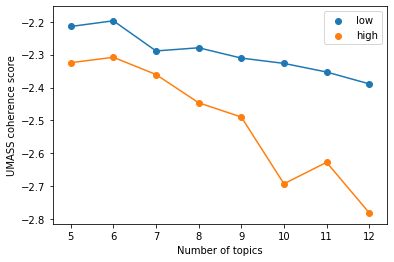

In [116]:
textsLow_train = reviews_low_train
id2wordLow_train = Dictionary(textsLow_train)
corpusLow_train = [id2wordLow_train.doc2bow(text) for text in textsLow_train]

textsHigh_train = reviews_high_train
id2wordHigh_train = Dictionary(textsHigh_train)
corpusHigh_train = [id2wordHigh_train.doc2bow(text) for text in textsHigh_train]

coherenceLow_train, ldaModelsLow_train = lda_train(textsLow_train, id2wordLow_train, corpusLow_train)
coherenceHigh_train, ldaModelsHigh_train = lda_train(textsHigh_train, id2wordHigh_train, corpusHigh_train)

# plot coherence
plt.scatter(*zip(*coherenceLow_train), label = "low")
plt.plot(*zip(*coherenceLow_train))
plt.scatter(*zip(*coherenceHigh_train), label = "high")
plt.plot(*zip(*coherenceHigh_train))
plt.xlabel("Number of topics")
plt.ylabel("UMASS coherence score")
plt.legend()
plt.show()

In [145]:
def getModelTopics(k, *models):
    if len(models) == 2:
        modelsLow, modelsHigh = models
        return pd.DataFrame(data = {'low':modelsLow[k-5].print_topics(), 'high':modelsHigh[k-5].print_topics()})
    elif len(models) == 1:
        return pd.DataFrame(data = {'topics':models[0][k-5].print_topics()})

In [124]:
getModelTopics(9, ldaModelsLow_train, ldaModelsHigh_train)

,low,high
0,"(0, 0.016*""story"" + 0.014*""time"" + 0.011*""character"" + 0.010*""one"" + 0.008*""good"" + 0.007*""thing"" + 0.006*""scene"" + 0.005*""kid"" + 0.005*""bad"" + 0.005*""line"")","(0, 0.024*""good"" + 0.023*""character"" + 0.022*""great"" + 0.013*""story"" + 0.013*""one"" + 0.011*""time"" + 0.009*""lot"" + 0.008*""thing"" + 0.008*""comedy"" + 0.007*""first"")"
1,"(1, 0.014*""character"" + 0.012*""people"" + 0.010*""time"" + 0.008*""man"" + 0.008*""spider"" + 0.007*""story"" + 0.006*""one"" + 0.006*""nothing"" + 0.006*""disney"" + 0.005*""original"")","(1, 0.013*""people"" + 0.012*""child"" + 0.010*""kid"" + 0.010*""life"" + 0.009*""man"" + 0.008*""dog"" + 0.006*""real"" + 0.006*""story"" + 0.006*""great"" + 0.006*""one"")"
2,"(2, 0.019*""character"" + 0.014*""disney"" + 0.013*""one"" + 0.011*""story"" + 0.010*""time"" + 0.010*""good"" + 0.009*""first"" + 0.008*""star"" + 0.008*""sequel"" + 0.007*""actor"")","(2, 0.023*""disney"" + 0.014*""story"" + 0.013*""character"" + 0.011*""great"" + 0.010*""kid"" + 0.008*""song"" + 0.007*""good"" + 0.007*""music"" + 0.007*""little"" + 0.006*""time"")"
3,"(3, 0.016*""thing"" + 0.012*""one"" + 0.010*""child"" + 0.009*""first"" + 0.008*""bad"" + 0.008*""character"" + 0.008*""story"" + 0.007*""good"" + 0.007*""original"" + 0.006*""people"")","(3, 0.015*""good"" + 0.013*""star"" + 0.012*""story"" + 0.011*""character"" + 0.008*""wars"" + 0.007*""great"" + 0.006*""one"" + 0.005*""war"" + 0.005*""robin"" + 0.005*""scene"")"
4,"(4, 0.015*""time"" + 0.010*""acting"" + 0.010*""good"" + 0.009*""nothing"" + 0.009*""first"" + 0.008*""character"" + 0.008*""people"" + 0.008*""plot"" + 0.007*""bad"" + 0.007*""way"")","(4, 0.032*""disney"" + 0.010*""time"" + 0.009*""channel"" + 0.006*""great"" + 0.006*""good"" + 0.005*""child"" + 0.005*""book"" + 0.005*""character"" + 0.005*""original"" + 0.005*""family"")"
5,"(5, 0.024*""disney"" + 0.022*""bad"" + 0.015*""kid"" + 0.010*""one"" + 0.010*""good"" + 0.010*""channel"" + 0.008*""family"" + 0.008*""guy"" + 0.006*""new"" + 0.006*""version"")","(5, 0.016*""character"" + 0.011*""great"" + 0.010*""story"" + 0.010*""life"" + 0.009*""time"" + 0.007*""good"" + 0.006*""cast"" + 0.006*""part"" + 0.006*""new"" + 0.005*""people"")"
6,"(6, 0.013*""character"" + 0.009*""one"" + 0.007*""time"" + 0.006*""life"" + 0.006*""plot"" + 0.006*""good"" + 0.006*""actor"" + 0.005*""another"" + 0.005*""story"" + 0.005*""original"")","(6, 0.026*""family"" + 0.019*""kid"" + 0.018*""good"" + 0.017*""story"" + 0.012*""great"" + 0.010*""character"" + 0.010*""one"" + 0.009*""time"" + 0.009*""disney"" + 0.007*""adult"")"
7,"(7, 0.018*""character"" + 0.014*""kid"" + 0.009*""one"" + 0.008*""story"" + 0.007*""people"" + 0.007*""plot"" + 0.007*""nothing"" + 0.007*""thing"" + 0.006*""good"" + 0.006*""actor"")","(7, 0.009*""character"" + 0.009*""great"" + 0.008*""way"" + 0.007*""one"" + 0.007*""good"" + 0.006*""time"" + 0.006*""phineas"" + 0.006*""people"" + 0.005*""cast"" + 0.005*""kid"")"
8,"(8, 0.012*""character"" + 0.007*""people"" + 0.007*""one"" + 0.007*""something"" + 0.007*""old"" + 0.006*""good"" + 0.006*""man"" + 0.006*""story"" + 0.005*""daughter"" + 0.004*""life"")","(8, 0.008*""great"" + 0.007*""time"" + 0.007*""man"" + 0.007*""action"" + 0.007*""one"" + 0.006*""scene"" + 0.006*""cast"" + 0.006*""performance"" + 0.005*""good"" + 0.005*""version"")"


**Observations**:
- **character** and **story/ plot** are aspects that both high and low reviews are concerned about
- aspects from **high** reviews and not in low reviews:
    - song/ music (from word occurences identified in Topic 2) ==> good music is a bonus, but not key factor in determining the ratings of a film
    - family (Topic 6) ==> family-friendliness is a selling point of Disney+
- aspects from **low** reviews and not in high reviews:
    - actor/ acting (Topic 2,4,7) ==> negative reviews seem to be associated with poor acting

In [641]:
from gensim.corpora.dictionary import Dictionary
textsLow_train = reviews_low_train
id2wordLow_train = Dictionary(textsLow_train)
corpusLow_train = [id2wordLow_train.doc2bow(text) for text in textsLow_train]

textsHigh_train = reviews_high_train
id2wordHigh_train = Dictionary(textsHigh_train)
corpusHigh_train = [id2wordHigh_train.doc2bow(text) for text in textsHigh_train]

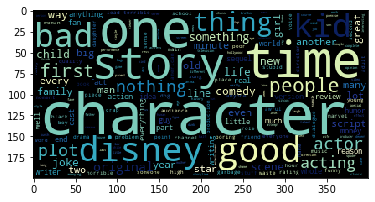

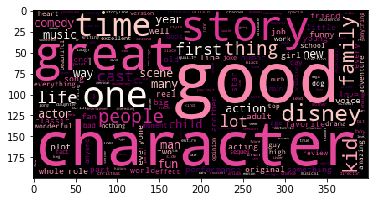

In [649]:
# generating word cloud
dLow_train = {}
for key, val in id2wordLow_train.cfs.items():
    token = id2wordLow_train[key]
    dLow_train[token] = val
dHigh_train = {}
for key, val in id2wordHigh_train.cfs.items():
    token = id2wordHigh_train[key]
    dHigh_train[token] = val

plt.imshow(WordCloud(colormap="YlGnBu").fit_words(dLow_train))
WordCloud(colormap="YlGnBu", width=800, height=400).fit_words(dLow_train).to_file('reviews_low_lda.png')
plt.show()
plt.imshow(WordCloud(colormap="RdPu").fit_words(dHigh_train))
WordCloud(colormap="RdPu", width=800, height=400).fit_words(dHigh_train).to_file('reviews_high_lda.png')
plt.show()

In [630]:
'''
# saving models and coherence scores in jupyter notebook
#%store ldaModelsLow_train
#%store ldaModelsHigh_train
#%store coherenceLow_train
#%store coherenceHigh_train
%store -r reviews_low_train
%store -r reviews_high_train
%store -r reviews_low_all
%store -r reviews_high_all

from gensim.test.utils import datapath

for i in range(8):
    temp_file_High_train = datapath("ldaHighTrain_" + str(i + 5))
    ldaHigh = ldaModelsHigh_train[i]
    ldaHigh.save(temp_file_High_train)
    temp_file_Low_train = datapath("ldaLowTrain_" + str(i + 5))
    ldaLow = ldaModelsLow_train[i]
    ldaLow.save(temp_file_Low_train)
'''

'\n# tbh idk where exactly these variables are stored using gensim,\n# but apparently LdaModel.load(temp_file_xxx) can load the saved model from disk\nfrom gensim.test.utils import datapath\n\nfor i in range(8):\n    temp_file_High_train = datapath("ldaHighTrain_" + str(i + 5))\n    ldaHigh = ldaModelsHigh_train[i]\n    ldaHigh.save(temp_file_High_train)\n    temp_file_Low_train = datapath("ldaLowTrain_" + str(i + 5))\n    ldaLow = ldaModelsLow_train[i]\n    ldaLow.save(temp_file_Low_train)\n'

##### - Convert text data to a feature
Can also consider feature cross between helpful_score and word embedding since reviews with helpful_score > 0 are more substantial (less narrative)

**Variables created**:

| (Word2Vec) | (GloVe) | Processed texts |
|---|---|---|
| w2v_train | unique_words_train | reviews_train |
| emb_df_train | glv_emb_df_train | reviews_test |
| w2v_featureArray_train | glv_featureArray_train |--|
| w2v_featureArray_test | glv_featureArray_test |--|

In [552]:
# list of tokenized and lemmatized words for train and test
# only consider nouns to reduce noise
reviews_train = preprocess_texts(X_combined_train_transformed.review, True)
reviews_test = preprocess_texts(X_combined_test_transformed.review, True)

In [14]:
%store -r reviews_train
%store -r reviews_test

**Word2Vec** Skip-Gram model
- *"According to the original paper, Mikolov et al., it is observed that the Skip-Gram model works well with a small amount of the training datasets, and can better represent rare words or phrases. However, the CBOW model is observed to train faster than Skip-Gram, and can better represent more frequent words which mean gives slightly better accuracy for the frequent words."*

In [554]:
w2v_train = Word2Vec(reviews_train, window=30, sg=1, negative=10)
# word embeddings
emb_df_train = (pd.DataFrame(
                            [w2v_train.wv.get_vector(str(n)) for n in w2v_train.wv.key_to_index],
                            index = w2v_train.wv.key_to_index
                        )
                    )

In [19]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [555]:
# document-level embedding (average word embeddings for each word present in each document)
w2v_featureArray_train = averaged_word_vectorizer(corpus=reviews_train, model=w2v_train,
                                             num_features=emb_df_train.shape[1])

w2v_featureArray_test = averaged_word_vectorizer(corpus=reviews_test, model=w2v_train,
                                             num_features=emb_df_train.shape[1])

**GloVe**

In [556]:
unique_words_train = list(set([word for sublist in [doc.split() for doc in X_combined_train_transformed.review] for word in sublist]))

glv_emb_df_train = np.array([nlp(word).vector for word in unique_words_train])

glv_featureArray_train = np.array([nlp(str(doc)).vector for doc in X_combined_train_transformed.review])
glv_featureArray_test = np.array([nlp(str(doc)).vector for doc in X_combined_test_transformed.review])

In [15]:
# Word2Vec
%store -r w2v_train
%store -r emb_df_train
%store -r w2v_featureArray_train
%store -r w2v_featureArray_test
#GloVe
%store -r unique_words_train
%store -r glv_emb_df_train
%store -r glv_featureArray_train
%store -r glv_featureArray_test

### Text (Review Title)

##### - LDA & WordCloud

In [130]:
reviewTitle_low_train = preprocess_texts(X_train_transformed[(X_train_transformed.helpful_score > 0) & (X_train_transformed.review_rating <= 3)].review_title, False)
reviewTitle_high_train = preprocess_texts(X_train_transformed[(X_train_transformed.helpful_score > 0) & (X_train_transformed.review_rating >= 8)].review_title, False)

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12


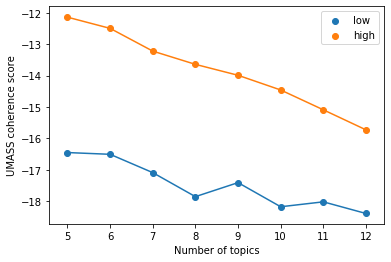

In [131]:
textsLow_rtitle_train = reviewTitle_low_train
id2wordLow_rtitle_train = Dictionary(textsLow_rtitle_train)
corpusLow_rtitle_train = [id2wordLow_rtitle_train.doc2bow(text) for text in textsLow_rtitle_train]

textsHigh_rtitle_train = reviewTitle_high_train
id2wordHigh_rtitle_train = Dictionary(textsHigh_rtitle_train)
corpusHigh_rtitle_train = [id2wordHigh_rtitle_train.doc2bow(text) for text in textsHigh_rtitle_train]

coherenceLow_rtitle_train, ldaModelsLow_rtitle_train = lda_train(textsLow_rtitle_train, id2wordLow_rtitle_train, corpusLow_rtitle_train)
coherenceHigh_rtitle_train, ldaModelsHigh_rtitle_train = lda_train(textsHigh_rtitle_train, id2wordHigh_rtitle_train, corpusHigh_rtitle_train)

# plot coherence
plt.scatter(*zip(*coherenceLow_rtitle_train), label = "low")
plt.plot(*zip(*coherenceLow_rtitle_train))
plt.scatter(*zip(*coherenceHigh_rtitle_train), label = "high")
plt.plot(*zip(*coherenceHigh_rtitle_train))
plt.xlabel("Number of topics")
plt.ylabel("UMASS coherence score")
plt.legend()
plt.show()

In [143]:
getModelTopics(12, ldaModelsLow_rtitle_train, ldaModelsHigh_rtitle_train)

,low,high
0,"(0, 0.050*""great"" + 0.035*""crap"" + 0.019*""stupid"" + 0.019*""sequel"" + 0.015*""poorly"" + 0.011*""still"" + 0.010*""sorry"" + 0.010*""typical"" + 0.010*""put"" + 0.009*""excuse"")","(0, 0.243*""love"" + 0.071*""excellent"" + 0.026*""wow"" + 0.025*""enjoy"" + 0.016*""cancel"" + 0.010*""favourite"" + 0.008*""yes"" + 0.008*""fox"" + 0.007*""king"" + 0.007*""absolute"")"
1,"(1, 0.150*""bad"" + 0.057*""disney"" + 0.033*""well"" + 0.027*""garbage"" + 0.025*""much"" + 0.016*""would"" + 0.015*""another"" + 0.015*""weak"" + 0.014*""think"" + 0.013*""review"")","(1, 0.297*""good"" + 0.075*""one"" + 0.034*""wonderful"" + 0.032*""original"" + 0.032*""ever"" + 0.026*""disney"" + 0.015*""pretty"" + 0.014*""surprisingly"" + 0.014*""christmas"" + 0.014*""masterpiece"")"
2,"(2, 0.054*""get"" + 0.038*""kid"" + 0.018*""know"" + 0.014*""never"" + 0.014*""need"" + 0.014*""like"" + 0.013*""wrong"" + 0.011*""plain"" + 0.011*""act"" + 0.010*""go"")","(2, 0.062*""make"" + 0.051*""best"" + 0.042*""ever"" + 0.042*""entertaining"" + 0.030*""perfect"" + 0.023*""laugh"" + 0.018*""heart"" + 0.016*""disney"" + 0.015*""new"" + 0.015*""one"")"
3,"(3, 0.082*""terrible"" + 0.063*""time"" + 0.060*""horrible"" + 0.058*""waste"" + 0.021*""wow"" + 0.018*""disappointment"" + 0.012*""cancel"" + 0.012*""big"" + 0.012*""zero"" + 0.012*""unfunny"")","(3, 0.068*""classic"" + 0.067*""disney"" + 0.063*""kid"" + 0.050*""great"" + 0.018*""incredible"" + 0.018*""adult"" + 0.017*""surprise"" + 0.015*""drama"" + 0.011*""thriller"" + 0.011*""fantasy"")"
4,"(4, 0.094*""watch"" + 0.024*""suck"" + 0.019*""like"" + 0.018*""people"" + 0.016*""mess"" + 0.015*""two"" + 0.015*""worth"" + 0.014*""annoying"" + 0.013*""complete"" + 0.010*""garbage"")","(4, 0.050*""brilliant"" + 0.040*""really"" + 0.030*""nice"" + 0.028*""first"" + 0.027*""star"" + 0.022*""sweet"" + 0.022*""hate"" + 0.021*""childhood"" + 0.017*""gem"" + 0.014*""wars"")"
5,"(5, 0.048*""funny"" + 0.033*""nothing"" + 0.027*""poor"" + 0.021*""oh"" + 0.020*""original"" + 0.016*""absolutely"" + 0.015*""well"" + 0.015*""could"" + 0.013*""fun"" + 0.010*""fake"")","(5, 0.119*""well"" + 0.029*""action"" + 0.026*""beautiful"" + 0.026*""bad"" + 0.021*""much"" + 0.021*""expect"" + 0.018*""disney"" + 0.017*""one"" + 0.016*""get"" + 0.014*""first"")"
6,"(6, 0.036*""go"" + 0.035*""trash"" + 0.026*""hate"" + 0.018*""love"" + 0.016*""idea"" + 0.010*""meh"" + 0.009*""pure"" + 0.009*""ridiculous"" + 0.009*""want"" + 0.008*""mediocre"")","(6, 0.247*""great"" + 0.038*""hilarious"" + 0.030*""cute"" + 0.030*""year"" + 0.020*""fun"" + 0.016*""still"" + 0.016*""lot"" + 0.014*""absolutely"" + 0.012*""comedy"" + 0.010*""finally"")"
7,"(7, 0.025*""first"" + 0.023*""minute"" + 0.021*""man"" + 0.018*""expect"" + 0.017*""even"" + 0.016*""take"" + 0.013*""blah"" + 0.013*""away"" + 0.010*""life"" + 0.010*""spider"")","(7, 0.063*""awesome"" + 0.045*""fantastic"" + 0.026*""way"" + 0.016*""think"" + 0.015*""miss"" + 0.014*""far"" + 0.012*""every"" + 0.012*""never"" + 0.010*""child"" + 0.009*""many"")"
8,"(8, 0.094*""good"" + 0.071*""boring"" + 0.058*""really"" + 0.035*""comedy"" + 0.033*""disappointing"" + 0.015*""unwatchable"" + 0.013*""try"" + 0.013*""lame"" + 0.012*""laugh"" + 0.012*""give"")","(8, 0.030*""back"" + 0.021*""review"" + 0.020*""entertain"" + 0.020*""bring"" + 0.017*""give"" + 0.017*""little"" + 0.016*""top"" + 0.013*""say"" + 0.012*""please"" + 0.012*""come"")"
9,"(9, 0.020*""note"" + 0.016*""happen"" + 0.014*""insult"" + 0.014*""hard"" + 0.014*""real"" + 0.014*""way"" + 0.012*""disney"" + 0.012*""child"" + 0.012*""fail"" + 0.010*""year"")","(9, 0.099*""fun"" + 0.088*""funny"" + 0.077*""family"" + 0.039*""comedy"" + 0.029*""enjoyable"" + 0.015*""charming"" + 0.014*""animated"" + 0.012*""entertainment"" + 0.011*""man"" + 0.010*""interesting"")"


**Observations**:
- in general, the words in review titles describe sentiments towards the films without a clear topic

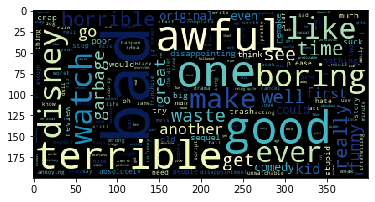

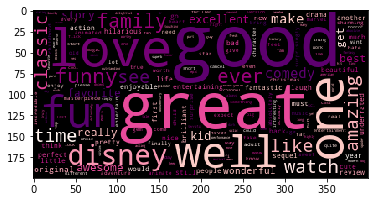

In [653]:
# generating word cloud
dLow_rtitle_train = {}
for key, val in id2wordLow_rtitle_train.cfs.items():
    token = id2wordLow_rtitle_train[key]
    dLow_rtitle_train[token] = val
dHigh_rtitle_train = {}
for key, val in id2wordHigh_rtitle_train.cfs.items():
    token = id2wordHigh_rtitle_train[key]
    dHigh_rtitle_train[token] = val

plt.imshow(WordCloud(colormap="YlGnBu").fit_words(dLow_rtitle_train))
WordCloud(colormap="YlGnBu", width=800, height=400).fit_words(dLow_rtitle_train).to_file('rTitle_low_lda.png')
plt.show()
plt.imshow(WordCloud(colormap="RdPu").fit_words(dHigh_rtitle_train))
WordCloud(colormap="RdPu", width=800, height=400).fit_words(dHigh_rtitle_train).to_file('rTitle_high_lda.png')
plt.show()

- Using CountVectorizer may be a good idea to represent the review titles as vectors

In [650]:
'''
# saving models and coherence scores in jupyter notebook
#%store ldaModelsLow_rtitle_train
#%store ldaModelsHigh_rtitle_train
#%store coherenceLow_rtitle_train
#%store coherenceHigh_rtitle_train
%store -r reviewTitle_low_train
%store -r reviewTitle_high_train

for i in range(8):
    temp_file_High_train = datapath("ldaHighTrain_rtitle_" + str(i + 5))
    ldaHigh = ldaModelsHigh_rtitle_train[i]
    ldaHigh.save(temp_file_High_train)
    temp_file_Low_train = datapath("ldaLowTrain_rtitle_" + str(i + 5))
    ldaLow = ldaModelsLow_rtitle_train[i]
    ldaLow.save(temp_file_Low_train)
'''

'\nfor i in range(8):\n    temp_file_High_train = datapath("ldaHighTrain_rtitle_" + str(i + 5))\n    ldaHigh = ldaModelsHigh_rtitle_train[i]\n    ldaHigh.save(temp_file_High_train)\n    temp_file_Low_train = datapath("ldaLowTrain_rtitle_" + str(i + 5))\n    ldaLow = ldaModelsLow_rtitle_train[i]\n    ldaLow.save(temp_file_Low_train)\n'

##### - Convert text data (both train and test) to a feature
Can also consider feature cross between helpful_score and word embedding since review titles with helpful_score > 0 are more substantial

**Variables created**:

| (Word2Vec) | (GloVe) | Processed texts |
|---|---|--|
| w2v_rtitle_train | unique_words_rtitle_train | reviewTitle_train |
| emb_df_rtitle_train | glv_emb_df_rtitle_train | reviewTitle_test |
| w2v_rtitle_featureArray_train | glv_rtitle_featureArray_train |--|
| w2v_rtitle_featureArray_test | glv_rtitle_featureArray_test |--|

In [558]:
# list of tokenized and lemmatized words for train and test
reviewTitle_train = preprocess_texts(X_combined_train_transformed.review_title, False)
reviewTitle_test = preprocess_texts(X_combined_test_transformed.review_title, False)

In [12]:
%store -r reviewTitle_train
%store -r reviewTitle_test

**Word2Vec** Skip-Gram model
- *"According to the original paper, Mikolov et al., it is observed that the Skip-Gram model works well with a small amount of the training datasets, and can better represent rare words or phrases. However, the CBOW model is observed to train faster than Skip-Gram, and can better represent more frequent words which mean gives slightly better accuracy for the frequent words."*

In [560]:
w2v_rtitle_train = Word2Vec(reviewTitle_train, window=3, sg=1, negative=10)
# word embeddings
emb_df_rtitle_train = (pd.DataFrame(
                            [w2v_rtitle_train.wv.get_vector(str(n)) for n in w2v_rtitle_train.wv.key_to_index],
                            index = w2v_rtitle_train.wv.key_to_index
                        )
                    )

In [561]:
# document-level embedding (average word embeddings for each word present in each document)
w2v_rtitle_featureArray_train = averaged_word_vectorizer(corpus=reviewTitle_train, model=w2v_rtitle_train,
                                             num_features=emb_df_rtitle_train.shape[1])

w2v_rtitle_featureArray_test = averaged_word_vectorizer(corpus=reviewTitle_test, model=w2v_rtitle_train,
                                             num_features=emb_df_rtitle_train.shape[1])

**GloVe**

In [562]:
unique_words_rtitle_train = list(set([word for sublist in [doc.split() for doc in X_combined_train_transformed.review_title] for word in sublist]))

glv_emb_df_rtitle_train = np.array([nlp(word).vector for word in unique_words_rtitle_train])

glv_rtitle_featureArray_train = np.array([nlp(str(doc)).vector for doc in X_combined_train_transformed.review_title])
glv_rtitle_featureArray_test = np.array([nlp(str(doc)).vector for doc in X_combined_test_transformed.review_title])

In [13]:
# Word2Vec
%store -r w2v_rtitle_train
%store -r emb_df_rtitle_train
%store -r w2v_rtitle_featureArray_train
%store -r w2v_rtitle_featureArray_test
#GloVe
%store -r unique_words_rtitle_train
%store -r glv_emb_df_rtitle_train
%store -r glv_rtitle_featureArray_train
%store -r glv_rtitle_featureArray_test

### Text (Sypnosis)

##### - Convert text data (both train and test) to a feature
- not doing topic modelling here as topics are well-represented by genre

**Variables created**:

| (Word2Vec) | (GloVe) | Processed texts |
|---|---|---|
| w2v_sypnosis_train | unique_words_sypnosis_train | sypnosis_train |
| emb_df_sypnosis_train | glv_emb_df_sypnosis_train | sypnosis_test |
| w2v_sypnosis_featureArray_train | glv_sypnosis_featureArray_train |--|
| w2v_sypnosis_featureArray_test | glv_sypnosis_featureArray_test |--|

In [1039]:
# list of tokenized and lemmatized words for train and test
sypnosis_train = preprocess_texts(X_shows_train_trimmed.sypnosis, False)
sypnosis_test = preprocess_texts(X_shows_test_trimmed.sypnosis, False)

In [16]:
%store -r sypnosis_train
%store -r sypnosis_test

**Word2Vec** Skip-Gram model
- *"According to the original paper, Mikolov et al., it is observed that the Skip-Gram model works well with a small amount of the training datasets, and can better represent rare words or phrases. However, the CBOW model is observed to train faster than Skip-Gram, and can better represent more frequent words which mean gives slightly better accuracy for the frequent words."*

In [1041]:
w2v_sypnosis_train = Word2Vec(sypnosis_train, window=3, sg=1, negative=10)
# word embeddings
emb_df_sypnosis_train = (pd.DataFrame(
                            [w2v_sypnosis_train.wv.get_vector(str(n)) for n in w2v_sypnosis_train.wv.key_to_index],
                            index = w2v_sypnosis_train.wv.key_to_index
                        )
                    )

In [1043]:
# document-level embedding (average word embeddings for each word present in each document)
w2v_sypnosis_featureArray_train = averaged_word_vectorizer(corpus=sypnosis_train, model=w2v_sypnosis_train,
                                             num_features=emb_df_sypnosis_train.shape[1])

w2v_sypnosis_featureArray_test = averaged_word_vectorizer(corpus=sypnosis_test, model=w2v_sypnosis_train,
                                             num_features=emb_df_sypnosis_train.shape[1])

**GloVe**

In [1044]:
unique_words_sypnosis_train = list(set([word for sublist in [doc.split() for doc in X_shows_train_trimmed.sypnosis] for word in sublist]))

glv_emb_df_sypnosis_train = np.array([nlp(word).vector for word in unique_words_sypnosis_train])

glv_sypnosis_featureArray_train = np.array([nlp(str(doc)).vector for doc in X_shows_train_trimmed.sypnosis])
glv_sypnosis_featureArray_test = np.array([nlp(str(doc)).vector for doc in X_shows_test_trimmed.sypnosis])

In [17]:
# Word2Vec
%store -r w2v_sypnosis_train
%store -r emb_df_sypnosis_train
%store -r w2v_sypnosis_featureArray_train
%store -r w2v_sypnosis_featureArray_test
#GloVe
%store -r unique_words_sypnosis_train
%store -r glv_emb_df_sypnosis_train
%store -r glv_sypnosis_featureArray_train
%store -r glv_sypnosis_featureArray_test

In [1046]:
glv_sypnosis_featureArray_train.shape

(1285, 300)

### Review Date
- can indicate the more up-to-date views and sentiments on the films
- converted to numeric values and normalized them
- each show has a corresponding vector of length 200 that contains the dates of its reviews

In [18]:
# convert timestamp to numeric (int)
X_combined_train_transformed['date'] = X_combined_train_transformed.date.astype(int)
X_combined_test_transformed['date'] = X_combined_test_transformed.date.astype(int)
# normalize timestamp
timestamp_train_mean = X_combined_train_transformed[['date']].mean()
timestamp_train_std = X_combined_train_transformed[['date']].std()
timestamp_train_norm = (X_combined_train_transformed[['date']] - timestamp_train_mean)/ timestamp_train_std
timestamp_test_norm = (X_combined_test_transformed[['date']] - timestamp_train_mean)/ timestamp_train_std

X_combined_train_transformed['date'] = timestamp_train_norm
X_combined_test_transformed['date'] = timestamp_test_norm

/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_879/2650950266.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_combined_train_transformed['date'] = X_combined_train_transformed.date.astype(int)
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_879/2650950266.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_combined_test_transformed['date'] = X_combined_test_transformed.date.astype(int)


In [19]:
X_train_reviewDate = []
for st in X_shows_train_trimmed.show_title:
    X_train_reviewDate.append(X_combined_train_transformed[X_combined_train_transformed.show_title.isin([st])].date.tolist())
    
X_test_reviewDate = []
for st in X_shows_test_trimmed.show_title:
    X_test_reviewDate.append(X_combined_test_transformed[X_combined_test_transformed.show_title.isin([st])].date.tolist())

# pad with zeros since shows each has different number of reviews, set max as 200 reviews each
X_train_reviewDate = tf.keras.preprocessing.sequence.pad_sequences(X_train_reviewDate, maxlen=200, dtype='float64', padding='post')
X_test_reviewDate = tf.keras.preprocessing.sequence.pad_sequences(X_test_reviewDate, maxlen=200, dtype='float64', padding='post')

### Helpful Score

In [20]:
X_train_helpfulScore = []
for st in X_shows_train_trimmed.show_title:
    X_train_helpfulScore.append(X_combined_train_transformed[X_combined_train_transformed.show_title.isin([st])].helpful_score.tolist())
    
X_test_helpfulScore = []
for st in X_shows_test_trimmed.show_title:
    X_test_helpfulScore.append(X_combined_test_transformed[X_combined_test_transformed.show_title.isin([st])].helpful_score.tolist())

# pad with zeros since shows each has different number of reviews, set max as 200 reviews each
X_train_helpfulScore = tf.keras.preprocessing.sequence.pad_sequences(X_train_helpfulScore, maxlen=200, dtype='float64', padding='post')
X_test_helpfulScore = tf.keras.preprocessing.sequence.pad_sequences(X_test_helpfulScore, maxlen=200, dtype='float64', padding='post')

### Genre

In [21]:
vect = CountVectorizer()
X_train_genre_dtm = vect.fit_transform(X_shows_train_trimmed.genre)
X_test_genre_dtm = vect.transform(X_shows_test_trimmed.genre)

In [22]:
X_train_genre_dtm.shape

(1285, 29)

### PG

In [23]:
vect2 = CountVectorizer()
X_train_pg_dtm = vect2.fit_transform(X_shows_train_trimmed.pg)
X_test_pg_dtm = vect2.transform(X_shows_test_trimmed.pg)

In [268]:
X_train_pg_dtm.shape

(1285, 11)

### Processing word embeddings so they can be used as inputs to NN
Aim: aggregate text data (Reviews and Review Titles) into {show_title: review_matrix} mappings

##### 1. Create {show_title: doc embedding matrix} mappings

In [24]:
# get {show_title: doc embedding matrix} mappings
# input df is of the form [show_title, embedding_dim1, embedding_dim2, embedding_dim3, ..., embedding_dimn]
def get_show2docEmbeddings(df):
    d = {}
    for i in range(df.shape[0]):
        st = df.show_title[i]
        if st not in d:
            d[st] = []
        d[st].append(df.iloc[i, 1:].to_list())
    for st in d.keys():
        #d[st].extend([[0]*100]*(200-len(d[st]))) # pad with zeros
        d[st] = np.array(d[st])
    return d

In [25]:
# for training dataset, word2vec
X_train_show2reviewEmbeddings_w2v = get_show2docEmbeddings(pd.concat(
                                            [X_combined_train_transformed[['show_title']], 
                                            pd.DataFrame(w2v_featureArray_train)], axis=1))
X_train_show2rTitleEmbeddings_w2v = get_show2docEmbeddings(pd.concat(
                                            [X_combined_train_transformed[['show_title']], 
                                            pd.DataFrame(w2v_rtitle_featureArray_train)], axis=1))
# for test dataset, word2vec
X_test_show2reviewEmbeddings_w2v = get_show2docEmbeddings(pd.concat(
                                            [X_combined_test_transformed[['show_title']], 
                                            pd.DataFrame(w2v_featureArray_test)], axis=1))
X_test_show2rTitleEmbeddings_w2v = get_show2docEmbeddings(pd.concat(
                                            [X_combined_test_transformed[['show_title']], 
                                            pd.DataFrame(w2v_rtitle_featureArray_test)], axis=1))

In [26]:
# for training dataset, glove
X_train_show2reviewEmbeddings_glv = get_show2docEmbeddings(pd.concat(
                                            [X_combined_train_transformed[['show_title']], 
                                            pd.DataFrame(glv_featureArray_train)], axis=1))
X_train_show2rTitleEmbeddings_glv = get_show2docEmbeddings(pd.concat(
                                            [X_combined_train_transformed[['show_title']], 
                                            pd.DataFrame(glv_rtitle_featureArray_train)], axis=1))
# for test dataset, glove
X_test_show2reviewEmbeddings_glv = get_show2docEmbeddings(pd.concat(
                                            [X_combined_test_transformed[['show_title']], 
                                            pd.DataFrame(glv_featureArray_test)], axis=1))
X_test_show2rTitleEmbeddings_glv = get_show2docEmbeddings(pd.concat(
                                            [X_combined_test_transformed[['show_title']], 
                                            pd.DataFrame(glv_rtitle_featureArray_test)], axis=1))

##### 2. Create arrays where index i holds the document embedding (a matrix) of the show at index i of X_shows_train_trimmed dataframe

In [27]:
## FROM WORD2VEC WORD EMBEDDINGS
# train, word2vec
X_train_reviewEmbeddings_w2v = []
X_train_rTitleEmbeddings_w2v = []
for st in X_shows_train_trimmed.show_title:
    X_train_reviewEmbeddings_w2v.append(X_train_show2reviewEmbeddings_w2v[st])
    X_train_rTitleEmbeddings_w2v.append(X_train_show2rTitleEmbeddings_w2v[st])

# test, word2vec
X_test_reviewEmbeddings_w2v = []
X_test_rTitleEmbeddings_w2v = []
for st in X_shows_test_trimmed.show_title:
    X_test_reviewEmbeddings_w2v.append(X_test_show2reviewEmbeddings_w2v[st])
    X_test_rTitleEmbeddings_w2v.append(X_test_show2rTitleEmbeddings_w2v[st])

# pad with zeros since shows each has different number of reviews, set max as 200 reviews each
X_train_reviewEmbeddings_w2v = tf.keras.preprocessing.sequence.pad_sequences(X_train_reviewEmbeddings_w2v, maxlen=200, dtype='float64', padding='post')
X_train_rTitleEmbeddings_w2v = tf.keras.preprocessing.sequence.pad_sequences(X_train_rTitleEmbeddings_w2v, maxlen=200, dtype='float64', padding='post')

X_test_reviewEmbeddings_w2v = tf.keras.preprocessing.sequence.pad_sequences(X_test_reviewEmbeddings_w2v, maxlen=200, dtype='float64', padding='post')
X_test_rTitleEmbeddings_w2v = tf.keras.preprocessing.sequence.pad_sequences(X_test_rTitleEmbeddings_w2v, maxlen=200, dtype='float64', padding='post')

In [28]:
## FROM GLOVE WORD EMBEDDINGS
# train, word2vec
X_train_reviewEmbeddings_glv = []
X_train_rTitleEmbeddings_glv = []
for st in X_shows_train_trimmed.show_title:
    X_train_reviewEmbeddings_glv.append(X_train_show2reviewEmbeddings_glv[st])
    X_train_rTitleEmbeddings_glv.append(X_train_show2rTitleEmbeddings_glv[st])
# test, word2vec
X_test_reviewEmbeddings_glv = []
X_test_rTitleEmbeddings_glv = []
for st in X_shows_test_trimmed.show_title:
    X_test_reviewEmbeddings_glv.append(X_test_show2reviewEmbeddings_glv[st])
    X_test_rTitleEmbeddings_glv.append(X_test_show2rTitleEmbeddings_glv[st])
# pad with zeros
X_train_reviewEmbeddings_glv = tf.keras.preprocessing.sequence.pad_sequences(X_train_reviewEmbeddings_glv, maxlen=200, dtype='float64', padding='post')
X_train_rTitleEmbeddings_glv = tf.keras.preprocessing.sequence.pad_sequences(X_train_rTitleEmbeddings_glv, maxlen=200, dtype='float64', padding='post')

X_test_reviewEmbeddings_glv = tf.keras.preprocessing.sequence.pad_sequences(X_test_reviewEmbeddings_glv, maxlen=200, dtype='float64', padding='post')
X_test_rTitleEmbeddings_glv = tf.keras.preprocessing.sequence.pad_sequences(X_test_rTitleEmbeddings_glv, maxlen=200, dtype='float64', padding='post')

In [217]:
X_train_reviewEmbeddings_glv.shape

(1285, 200, 300)

##### 3. train neural network :")
We want the neural network to be capable of handling mixed data (numerical, categorical, tensor/ matrix). Done by using Keras' functional API rather than the usual Sequential API since Keras can handle multiple inputs using functional API.

In the following model the inputs are document embeddings of reviews and review titles corresponding to each show. Currently we don't include the numerical and categorical data of each show yet.

# Neural Network on review-specific data with PG and Genre

In [29]:
def createModel(r=True, rTitles=True, date=True, helpfulScore=True, sypnosis=True, metadata=True):
    input_reviews = Input(shape=(200, 300)) #(200,300) is shape of each reviewEmbedding derived from glove word embeddings
    input_rTitles = Input(shape=(200, 300))
    input_rDate = Input(shape=(200))
    input_rHelpfulScore = Input(shape=(200))
    input_sypnosis = Input(shape=(300))
    input_metadata = Input(shape=(40))

    x1 = layers.Flatten()(input_reviews)
    x1 = layers.Dense(100, activation="relu")(x1)
    x1 = layers.Dense(20, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x1)
    x1 = layers.Dropout(0.6)(x1)
    x1 = Model(inputs=input_reviews, outputs=x1)

    x2 = layers.Flatten()(input_rTitles)
    x2 = layers.Dense(100, activation="relu")(x2)
    x2 = layers.Dense(20, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x2)
    x2 = layers.Dropout(0.6)(x2)
    x2 = Model(inputs=input_rTitles, outputs=x2)

    x3 = layers.Flatten()(input_rDate)
    x3 = layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.2))(x3)
    x3 = layers.Dropout(0.6)(x3)
    x3 = Model(inputs=input_rDate, outputs=x3)

    x4 = layers.Flatten()(input_rHelpfulScore)
    x4 = layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.2))(x4)
    x4 = layers.Dropout(0.6)(x4)
    x4 = Model(inputs=input_rHelpfulScore, outputs=x4)

    x5 = layers.Flatten()(input_sypnosis)
    x5 = layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x5)
    x5 = layers.Dropout(0.6)(x5)
    x5 = Model(inputs=input_sypnosis, outputs=x5)

    x6 = layers.Flatten()(input_metadata)
    x6 = layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x6)
    x6 = layers.Dropout(0.5)(x6)
    x6 = Model(inputs=input_metadata, outputs=x6)

    output = []
    input = []
    for i in range(6):
        if [r, rTitles, date, helpfulScore, sypnosis, metadata][i]:
            output.append([x1.output, x2.output, x3.output, x4.output, x5.output, x6.output][i])
            input.append([x1.input, x2.input, x3.input, x4.input, x5.input, x6.input][i])
    
    combined = layers.concatenate(output)

    z = layers.Dense(120, activation="relu")(combined)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(10, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(z)
    z = layers.Dense(1, activation="linear")(z)

    model = Model(inputs=input, outputs=z)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200)
    model.compile(loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()], optimizer=opt)
    return model

In [30]:
X_train_metadata = hstack([X_train_genre_dtm, X_train_pg_dtm]).toarray()
X_test_metadata = hstack([X_test_genre_dtm, X_test_pg_dtm]).toarray()

##### model 3 -- all except review embeddings and review titles

In [435]:
model3 = createModel(r=False, rTitles=False)
hist3 = model3.fit(x=[tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                    tf.stack(glv_sypnosis_featureArray_train),
                    tf.stack(X_train_metadata)], 
                    y=tf.stack(y_train_trimmed), 
                    epochs=120, batch_size=32, validation_split=0.2, shuffle=True)

Epoch 1/120
33/33 [==============================] - 5s 24ms/step - loss: 58.6797 - mean_squared_error: 24.1949 - val_loss: 29.9547 - val_mean_squared_error: 3.0870
Epoch 2/120
33/33 [==============================] - 0s 12ms/step - loss: 25.7808 - mean_squared_error: 4.1063 - val_loss: 18.7522 - val_mean_squared_error: 1.9176
Epoch 3/120
33/33 [==============================] - 0s 12ms/step - loss: 16.9789 - mean_squared_error: 3.1517 - val_loss: 12.5683 - val_mean_squared_error: 1.5655
Epoch 4/120
33/33 [==============================] - 0s 8ms/step - loss: 12.0394 - mean_squared_error: 2.8272 - val_loss: 8.9916 - val_mean_squared_error: 1.4650
Epoch 5/120
33/33 [==============================] - 0s 8ms/step - loss: 8.8431 - mean_squared_error: 2.3926 - val_loss: 6.7806 - val_mean_squared_error: 1.3645
Epoch 6/120
33/33 [==============================] - 0s 9ms/step - loss: 7.3438 - mean_squared_error: 2.5916 - val_loss: 5.3394 - val_mean_squared_error: 1.2342
Epoch 7/120
33/33 [====

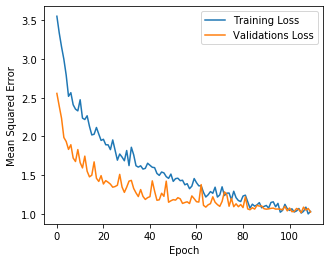

In [667]:
mse_train3, mse_val3 = hist3.history['loss'], hist3.history['val_loss']
plt.figure(figsize=(5,4))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(mse_train3[10:], label="Training Loss")
plt.plot(mse_val3[10:], label="Validations Loss")
plt.legend()
plt.savefig('model_loss_r3.png')
plt.show()

In [437]:
pred3 = model3.predict([tf.stack(X_test_reviewDate), tf.stack(X_test_helpfulScore), 
                        tf.stack(glv_sypnosis_featureArray_test),
                        tf.stack(X_test_metadata)
                        ])
print('mean_squared_error:', metrics.mean_squared_error(y_test_trimmed.rating, pred3))
print('r2_score:', metrics.r2_score(y_test_trimmed.rating, pred3))

pred_train3 = model3.predict([tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                            tf.stack(glv_sypnosis_featureArray_train),
                            tf.stack(X_train_metadata)
                            ])
print('mean_squared_error:', metrics.mean_squared_error(y_train_trimmed.rating, pred_train3))
print('r2_score:', metrics.r2_score(y_train_trimmed.rating, pred_train3))

mean_squared_error: 0.8339313300065103
r2_score: 0.2427506463775072
mean_squared_error: 0.6750468502009339
r2_score: 0.362672277387193


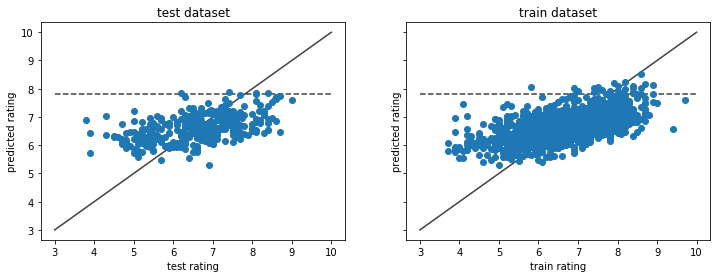

In [674]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
ax1.scatter(y_test_trimmed.rating, pred3)
plt.setp(ax1, xlabel='test rating', ylabel='predicted rating')
ax1.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax1.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax2.scatter(y_train_trimmed.rating, pred_train3)
plt.setp(ax2, xlabel='train rating', ylabel='predicted rating')
ax2.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax2.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax1.title.set_text("test dataset"); ax2.title.set_text("train dataset")
plt.savefig('model_pred_r3.png')
plt.show()

##### model 2 -- all except review embeddings

In [425]:
model2 = createModel(r=False)
hist2 = model2.fit(x=[tf.stack(X_train_rTitleEmbeddings_glv), 
                    tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                    tf.stack(glv_sypnosis_featureArray_train),
                    tf.stack(X_train_metadata)], 
                    y=tf.stack(y_train_trimmed), 
                    epochs=100, batch_size=32, validation_split=0.2, shuffle=True)

Epoch 1/100
33/33 [==============================] - 9s 124ms/step - loss: 52.2250 - mean_squared_error: 16.0647 - val_loss: 30.5163 - val_mean_squared_error: 2.4015
Epoch 2/100
33/33 [==============================] - 3s 76ms/step - loss: 26.8918 - mean_squared_error: 4.1324 - val_loss: 19.3012 - val_mean_squared_error: 1.6315
Epoch 3/100
33/33 [==============================] - 2s 66ms/step - loss: 17.5860 - mean_squared_error: 3.0699 - val_loss: 13.0588 - val_mean_squared_error: 1.5188
Epoch 4/100
33/33 [==============================] - 2s 69ms/step - loss: 12.5535 - mean_squared_error: 2.9026 - val_loss: 9.2097 - val_mean_squared_error: 1.3411
Epoch 5/100
33/33 [==============================] - 2s 68ms/step - loss: 9.4182 - mean_squared_error: 2.6763 - val_loss: 6.7638 - val_mean_squared_error: 1.1045
Epoch 6/100
33/33 [==============================] - 3s 83ms/step - loss: 7.2693 - mean_squared_error: 2.3158 - val_loss: 5.2983 - val_mean_squared_error: 1.0283
Epoch 7/100
33/33 [

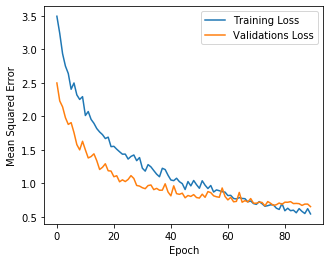

In [675]:
mse_train2, mse_val2 = hist2.history['loss'], hist2.history['val_loss']
plt.figure(figsize=(5,4))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(mse_train2[10:], label="Training Loss")
plt.plot(mse_val2[10:], label="Validations Loss")
plt.legend()
plt.savefig('model_loss_r2.png')
plt.show()

In [427]:
pred2 = model2.predict([#tf.stack(X_test_reviewEmbeddings_glv), 
                        tf.stack(X_test_rTitleEmbeddings_glv), 
                        tf.stack(X_test_reviewDate), tf.stack(X_test_helpfulScore), 
                        tf.stack(glv_sypnosis_featureArray_test),
                        tf.stack(X_test_metadata)
                        ])
print('mean_squared_error:', metrics.mean_squared_error(y_test_trimmed.rating, pred2))
print('r2_score:', metrics.r2_score(y_test_trimmed.rating, pred2))

pred_train2 = model2.predict([#tf.stack(X_train_reviewEmbeddings_glv), 
                            tf.stack(X_train_rTitleEmbeddings_glv), 
                            tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                            tf.stack(glv_sypnosis_featureArray_train),
                            tf.stack(X_train_metadata)
                            ])
print('mean_squared_error:', metrics.mean_squared_error(y_train_trimmed.rating, pred_train2))
print('r2_score:', metrics.r2_score(y_train_trimmed.rating, pred_train2))

mean_squared_error: 0.5650597244635215
r2_score: 0.4868988659956389
mean_squared_error: 0.18967773497620977
r2_score: 0.8209207570900298


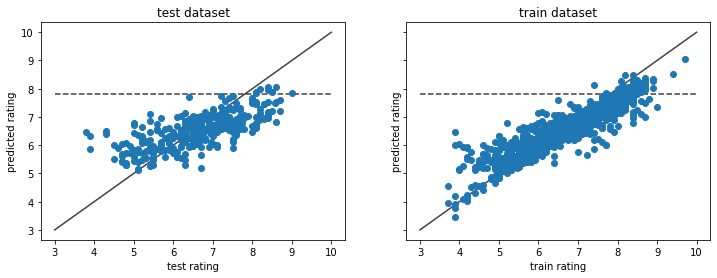

In [676]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
ax1.scatter(y_test_trimmed.rating, pred2)
plt.setp(ax1, xlabel='test rating', ylabel='predicted rating')
ax1.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax1.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax2.scatter(y_train_trimmed.rating, pred_train2)
plt.setp(ax2, xlabel='train rating', ylabel='predicted rating')
ax2.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax2.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax1.title.set_text("test dataset"); ax2.title.set_text("train dataset")
plt.savefig('model_pred_r2.png')
plt.show()

##### model 1 -- all

In [111]:
model = createModel()

hist = model.fit(x=[tf.stack(X_train_reviewEmbeddings_glv), tf.stack(X_train_rTitleEmbeddings_glv), 
                    tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                    tf.stack(glv_sypnosis_featureArray_train),
                    tf.stack(X_train_metadata)], 
                    y=tf.stack(y_train_trimmed), 
                    epochs=100, batch_size=32, validation_split=0.2, shuffle=True)

Epoch 1/100
33/33 [==============================] - 30s 814ms/step - loss: 55.6368 - mean_squared_error: 18.4695 - val_loss: 32.7378 - val_mean_squared_error: 4.0378
Epoch 2/100
33/33 [==============================] - 6s 172ms/step - loss: 28.0694 - mean_squared_error: 4.8711 - val_loss: 20.4646 - val_mean_squared_error: 2.4977
Epoch 3/100
33/33 [==============================] - 4s 127ms/step - loss: 18.0327 - mean_squared_error: 3.3597 - val_loss: 13.5082 - val_mean_squared_error: 1.9211
Epoch 4/100
33/33 [==============================] - 4s 118ms/step - loss: 12.4562 - mean_squared_error: 2.8302 - val_loss: 10.3467 - val_mean_squared_error: 2.5858
Epoch 5/100
33/33 [==============================] - 4s 133ms/step - loss: 9.3864 - mean_squared_error: 2.7674 - val_loss: 7.0089 - val_mean_squared_error: 1.4773
Epoch 6/100
33/33 [==============================] - 4s 124ms/step - loss: 7.1709 - mean_squared_error: 2.3431 - val_loss: 5.7418 - val_mean_squared_error: 1.5937
Epoch 7/100


In [45]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 200, 300)]   0           []                               
                                                                                                  
 flatten (Flatten)              (None, 60000)        0           ['input_1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 60000)        0           ['input_2[0][0]']                
                                                                                            

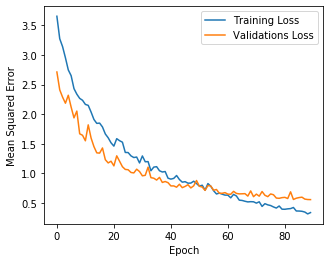

In [112]:
mse_train, mse_val = hist.history['loss'], hist.history['val_loss']
plt.figure(figsize=(5,4))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(mse_train[10:], label="Training Loss")
plt.plot(mse_val[10:], label="Validations Loss")
plt.legend()
plt.savefig('model_pred_r1.png')
plt.show()

In [113]:
pred = model.predict([tf.stack(X_test_reviewEmbeddings_glv), tf.stack(X_test_rTitleEmbeddings_glv), 
                        tf.stack(X_test_reviewDate), tf.stack(X_test_helpfulScore), 
                        tf.stack(glv_sypnosis_featureArray_test),
                        tf.stack(X_test_metadata)
                        ])
print('mean_squared_error:', metrics.mean_squared_error(y_test_trimmed.rating, pred))
print('r2_score:', metrics.r2_score(y_test_trimmed.rating, pred))

pred_train = model.predict([tf.stack(X_train_reviewEmbeddings_glv), tf.stack(X_train_rTitleEmbeddings_glv), 
                            tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                            tf.stack(glv_sypnosis_featureArray_train),
                            tf.stack(X_train_metadata)
                            ])
print('mean_squared_error:', metrics.mean_squared_error(y_train_trimmed.rating, pred_train))
print('r2_score:', metrics.r2_score(y_train_trimmed.rating, pred_train))

mean_squared_error: 0.45022270527791824
r2_score: 0.5911763471517348
mean_squared_error: 0.12253735957047651
r2_score: 0.8843095760141799


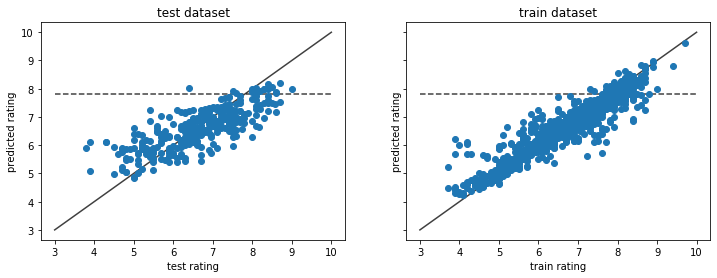

In [482]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
ax1.scatter(y_test_trimmed.rating, pred)
plt.setp(ax1, xlabel='test rating', ylabel='predicted rating')
ax1.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax1.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax2.scatter(y_train_trimmed.rating, pred_train)
plt.setp(ax2, xlabel='train rating', ylabel='predicted rating')
ax2.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax2.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax1.title.set_text("test dataset"); ax2.title.set_text("train dataset")
plt.savefig('model_pred_r1.png')
plt.show()

# Examine predictions from NN regression

In [ ]:
pd.set_option('display.max_rows', None)

In [40]:
predDiscretized = y_test_trimmed.copy()
predDiscretized['predicted_rating'] = pred
predDiscretized['rating'] = predDiscretized.rating.apply(lambda x: 2 if x >= 7.8 else (1 if x >= 7.1 else 0))
predDiscretized['predicted_rating'] = predDiscretized.predicted_rating.apply(lambda x: 2 if x >= 7.8 else (1 if x >= 7.1 else 0))

In [577]:
metrics.confusion_matrix(predDiscretized.rating, predDiscretized.predicted_rating)

array([[185,  17,   1],
       [ 40,  29,   2],
       [  9,  18,  15]])

### Ratings that are predicted to be higher than it actually is

In [376]:
predHigh = y_test_trimmed.iloc[np.where(pred.squeeze() >= 7.8)]
predHigh['predicted_rating'] = pred[np.where(pred.squeeze() >= 7.8)]
predHigh[predHigh.rating < 7.8]

/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_26296/605265429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predHigh['predicted_rating'] = pred[np.where(pred.squeeze() >= 7.8)]


,rating,predicted_rating
972,6.4,8.028301
10,7.6,7.831678
811,7.5,7.908534


These predictions are mostly around 0.4 away from actual rating, which is pretty decent. The only one with a huge difference is the row at index 972, so we will examine it.

In [615]:
fp = X_combined_test_transformed.loc[X_combined_test_transformed.show_title.isin(
                                    X_shows_test_trimmed.loc[predHigh[(predHigh.rating < 7.8)].index].show_title.to_numpy()
                                    )][['show_title', 'genre', 'review_title', 'review_rating']]

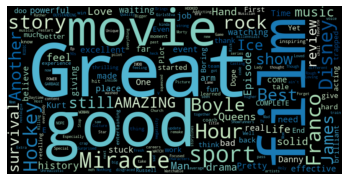

In [656]:
# generate word cloud
text_fp = " ".join(doc for doc in fp.review_title.to_numpy())
wordcloud_fp = WordCloud(collocations=False, colormap='GnBu', background_color='black', width=800, height=400).generate(text_fp).to_file('fp_rTitle.png')
plt.imshow(wordcloud_fp, interpolation='bilinear')
plt.axis("off")
plt.show()

Many reviews with low review ratings have misleading words in the review title, such as "like", "excellent", "star", "special", "strong", "solid", "great" and "good" which are positive. On the other hand, higher review ratings uses consistently positive words. Hence, when taken together, it is more likely for our model to output a higher predicted rating.

In [658]:
WordCloud(collocations=False, colormap='GnBu', background_color='black', width=800, height=400).generate(" ".join(doc for doc in fp.genre.to_numpy())).to_file('fp_genre.png')

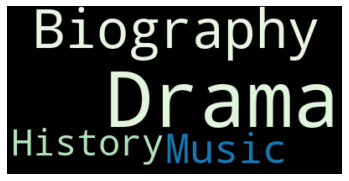

In [618]:
#tp.genre.unique()
plt.imshow(WordCloud(collocations=False, colormap='GnBu', background_color='black').generate(" ".join(doc for doc in fp.genre.to_numpy())), interpolation='bilinear')
plt.axis("off")
plt.show()

### Ratings that are predicted to be lower than it actually is

In [377]:
predLow = y_test_trimmed.iloc[np.where(pred.squeeze() < 7.8)]
predLow['predicted_rating'] = pred[np.where(pred.squeeze() < 7.8)]
predLow[(predLow.rating >= 7.8)]

/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_26296/2067871781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predLow['predicted_rating'] = pred[np.where(pred.squeeze() < 7.8)]


,rating,predicted_rating
194,7.800000,6.965555
1190,8.000000,6.295389
1098,8.100000,7.381255
1648,8.100000,7.745694
425,7.900000,7.131181
13,8.400000,7.508722
1417,8.000000,7.638574
528,8.400000,7.586894
1577,8.400000,7.207821
1331,8.575000,7.455660


As compared to false positive, there are many more false negative. 

In [378]:
fn = X_combined_test_transformed.loc[X_combined_test_transformed.show_title.isin(
                                    X_shows_test_trimmed.loc[predLow[(predLow.rating >= 7.8)].index].show_title.to_numpy()
                                    )][['show_title', 'genre', 'review_title', 'review_rating']]

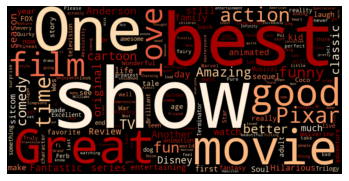

In [659]:
# generate word cloud
text_fn = " ".join(doc for doc in fn.review_title.to_numpy())
wordcloud_fn = WordCloud(collocations=False, colormap='OrRd_r', background_color='black', width=800, height=400).generate(text_fn).to_file('fn_rTitle.png')
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.axis("off")
plt.show()

We observe that most of these shows have the genre "Comedy".

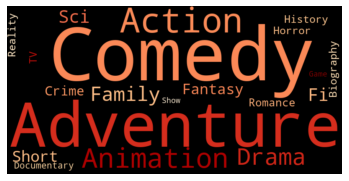

In [661]:
#fn.genre.unique()
plt.imshow(WordCloud(collocations=False, colormap='OrRd_r', background_color='black', width=800, height=400).generate(" ".join(doc for doc in fn.genre.to_numpy())).to_file('fn_genre.png'), interpolation='bilinear')
plt.axis("off")
plt.show()

### True positives and negatives

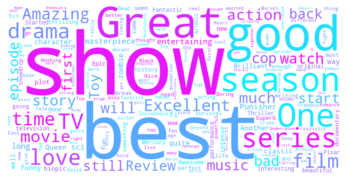

In [663]:
tp = X_combined_test_transformed.loc[X_combined_test_transformed.show_title.isin(
                                    X_shows_test_trimmed.loc[predHigh[(predHigh.rating >= 7.8)].index].show_title.to_numpy()
                                    )][['show_title', 'genre', 'review_title', 'review_rating']]
text_tp = " ".join(doc for doc in tp.review_title.to_numpy())
wordcloud_tp = WordCloud(collocations=False, colormap='cool_r', background_color='white', width=800, height=400).generate(text_tp).to_file('tp_rTitle.png')
plt.imshow(wordcloud_tp, interpolation='bilinear')
plt.axis("off")
plt.show()

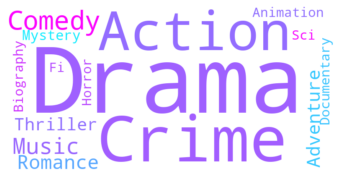

In [664]:
#tp.genre.unique()
plt.imshow(WordCloud(collocations=False, colormap='cool_r', background_color='white', width=800, height=400).generate(" ".join(doc for doc in tp.genre.to_numpy())).to_file('tp_genre.png'), interpolation='bilinear')
plt.axis("off")
plt.show()

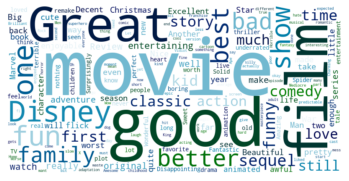

In [665]:
tn = X_combined_test_transformed.loc[X_combined_test_transformed.show_title.isin(
                                    X_shows_test_trimmed.loc[predLow[(predLow.rating < 7.8) & (predLow.predicted_rating < 7.8)].index].show_title.to_numpy()
                                    )][['show_title', 'genre', 'review_title', 'review_rating']]
text_tn = " ".join(doc for doc in tn.review_title.to_numpy())
wordcloud_tn = WordCloud(collocations=False, colormap='ocean_r', background_color='white', width=800, height=400).generate(text_tn).to_file('tn_rTitle.png')
plt.imshow(wordcloud_tn, interpolation='bilinear')
plt.axis("off")
plt.show()

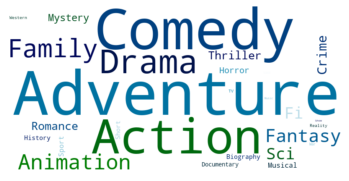

In [666]:
#tn.genre.unique()
plt.imshow(WordCloud(collocations=False, colormap='ocean_r', background_color='white', width=800, height=400).generate(" ".join(doc for doc in tn.genre.to_numpy())).to_file('tn_genre.png'), interpolation='bilinear')
plt.axis("off")
plt.show()

# Classification using NN

In [61]:
def createModel_classification():
    input_reviews = Input(shape=(200, 300)) #(200,300) is shape of each reviewEmbedding derived from glove word embeddings
    input_rTitles = Input(shape=(200, 300))
    input_rDate = Input(shape=(200))
    input_rHelpfulScore = Input(shape=(200))
    input_sypnosis = Input(shape=(300))
    input_metadata = Input(shape=(40))

    x1 = layers.Flatten()(input_reviews)
    x1 = layers.Dense(20, activation="relu")(x1)
    x1 = layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x1)
    x1 = layers.Dropout(0.6)(x1)
    x1 = Model(inputs=input_reviews, outputs=x1)

    x2 = layers.Flatten()(input_rTitles)
    x2 = layers.Dense(20, activation="relu")(x2)
    x2 = layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x2)
    x2 = layers.Dropout(0.6)(x2)
    x2 = Model(inputs=input_rTitles, outputs=x2)

    x3 = layers.Flatten()(input_rDate)
    x3 = layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.2))(x3)
    x3 = layers.Dropout(0.6)(x3)
    x3 = Model(inputs=input_rDate, outputs=x3)

    x4 = layers.Flatten()(input_rHelpfulScore)
    x4 = layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.2))(x4)
    x4 = layers.Dropout(0.6)(x4)
    x4 = Model(inputs=input_rHelpfulScore, outputs=x4)

    x5 = layers.Flatten()(input_sypnosis)
    x5 = layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x5)
    x5 = layers.Dropout(0.6)(x5)
    x5 = Model(inputs=input_sypnosis, outputs=x5)

    x6 = layers.Flatten()(input_metadata)
    x6 = layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(x6)
    x6 = layers.Dropout(0.5)(x6)
    x6 = Model(inputs=input_metadata, outputs=x6)
    
    combined = layers.concatenate([x1.output, 
                                    x2.output, 
                                    x3.output, x4.output, 
                                    x5.output,
                                    x6.output
                                ])

    z = layers.Dense(50, activation="relu")(combined)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05))(z)
    z = layers.Dense(3, activation="softmax")(z)

    model = Model(inputs=[x1.input, 
                            x2.input, 
                            x3.input, x4.input, 
                            x5.input,
                            x6.input
                        ], outputs=z)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200)
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)
    return model

In [48]:
# target values different from the code on shows dataset, as tensorflow input requires target to range from [0,2)
# so 0 represents the worst class and 2 represents the best here
y_train_trimmed_discretized = y_train_trimmed.copy()
y_train_trimmed_discretized['rating'] = y_train_trimmed_discretized.rating.apply(lambda x: 2 if x >= 7.8 else (1 if x >= 7.1 else 0))

y_test_trimmed_discretized = y_test_trimmed.copy()
y_test_trimmed_discretized['rating'] = y_test_trimmed_discretized.rating.apply(lambda x: 2 if x >= 7.8 else (1 if x >= 7.1 else 0))

In [62]:
model_classification = createModel_classification()

hist_classification = model_classification.fit(x=[tf.stack(X_train_reviewEmbeddings_glv), tf.stack(X_train_rTitleEmbeddings_glv), 
                                tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                                tf.stack(glv_sypnosis_featureArray_train),
                                tf.stack(X_train_metadata)], 
                                y=tf.stack(y_train_trimmed_discretized), 
                                epochs=100, batch_size=None, validation_split=0.2, shuffle=True)

Epoch 1/100
33/33 [==============================] - 4s 55ms/step - loss: 37.2441 - accuracy: 0.5778 - val_loss: 25.9017 - val_accuracy: 0.6031
Epoch 2/100
33/33 [==============================] - 1s 40ms/step - loss: 19.1871 - accuracy: 0.6430 - val_loss: 13.2538 - val_accuracy: 0.6031
Epoch 3/100
33/33 [==============================] - 1s 41ms/step - loss: 9.7701 - accuracy: 0.6430 - val_loss: 6.8464 - val_accuracy: 0.6031
Epoch 4/100
33/33 [==============================] - 1s 43ms/step - loss: 4.9828 - accuracy: 0.6488 - val_loss: 3.7356 - val_accuracy: 0.6109
Epoch 5/100
33/33 [==============================] - 1s 45ms/step - loss: 2.6183 - accuracy: 0.7461 - val_loss: 2.3453 - val_accuracy: 0.6109
Epoch 6/100
33/33 [==============================] - 1s 40ms/step - loss: 1.4818 - accuracy: 0.8123 - val_loss: 1.7492 - val_accuracy: 0.5837
Epoch 7/100
33/33 [==============================] - 2s 46ms/step - loss: 0.9205 - accuracy: 0.8210 - val_loss: 1.6546 - val_accuracy: 0.5914
Ep

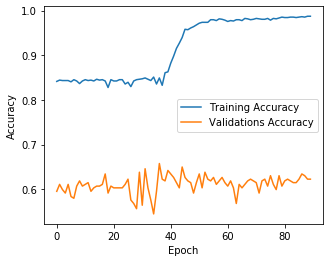

In [681]:
acc_train, acc_val = hist_classification.history['accuracy'], hist_classification.history['val_accuracy']
plt.figure(figsize=(5,4))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.plot(acc_train[10:], label="Training Accuracy")
plt.plot(acc_val[10:], label="Validations Accuracy")
plt.legend()
plt.show()

In [ ]:
pred_classification = model_classification.predict([tf.stack(X_test_reviewEmbeddings_glv), tf.stack(X_test_rTitleEmbeddings_glv), 
                                    tf.stack(X_test_reviewDate), tf.stack(X_test_helpfulScore), 
                                    tf.stack(glv_sypnosis_featureArray_test),
                                    tf.stack(X_test_metadata)
                                    ])
model_classification.evaluate(x=[tf.stack(X_test_reviewEmbeddings_glv), tf.stack(X_test_rTitleEmbeddings_glv), 
                                    tf.stack(X_test_reviewDate), tf.stack(X_test_helpfulScore), 
                                    tf.stack(glv_sypnosis_featureArray_test),
                                    tf.stack(X_test_metadata)
                                    ], y=tf.stack(y_test_trimmed_discretized.rating))

pred_train_classification = model_classification.predict([tf.stack(X_train_reviewEmbeddings_glv), tf.stack(X_train_rTitleEmbeddings_glv), 
                                        tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                                        tf.stack(glv_sypnosis_featureArray_train),
                                        tf.stack(X_train_metadata)
                                        ])
model_classification.evaluate(x=[tf.stack(X_train_reviewEmbeddings_glv), tf.stack(X_train_rTitleEmbeddings_glv), 
                                        tf.stack(X_train_reviewDate), tf.stack(X_train_helpfulScore), 
                                        tf.stack(glv_sypnosis_featureArray_train),
                                        tf.stack(X_train_metadata)
                                        ], y=tf.stack(y_train_trimmed_discretized.rating))

41/41 [==============================] - 1s 20ms/step - loss: 0.6855 - accuracy: 0.9144


[0.6854838132858276, 0.9143968820571899]

In [58]:
classes_test = pd.DataFrame({'true_class':y_test_trimmed_discretized.rating, 'predicted_class':np.argmax(pred_classification, axis=1)})

In [493]:
print("test confusion matrix: \n", metrics.confusion_matrix(classes_test.true_class, classes_test.predicted_class))
print("train confusion matrix: \n", metrics.confusion_matrix(y_train_trimmed_discretized.rating, np.argmax(pred_train_classification, axis=1)))

test confusion matrix: 
 [[185  18   0]
 [ 46  23   2]
 [  8  21  13]]
train confusion matrix: 
 [[796  16   4]
 [ 43 216  15]
 [ 11  21 163]]


In [65]:
model_classification.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 200, 300)]   0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 200, 300)]   0           []                               
                                                                                                  
 flatten_24 (Flatten)           (None, 60000)        0           ['input_25[0][0]']               
                                                                                                  
 flatten_25 (Flatten)           (None, 60000)        0           ['input_26[0][0]']               
                                                                                           

The model misses many shows that should have been accepted as top priority, but nevertheless most predicted true positives are indeed true.

In [71]:
fn_class2 = X_shows_test_trimmed.loc[classes_test[(classes_test.true_class == 2) & (classes_test.predicted_class < 2)].index]

fp_class2 = X_shows_test_trimmed.loc[classes_test[(classes_test.true_class < 2) & (classes_test.predicted_class == 2)].index]

tp_class2 = X_shows_test_trimmed.loc[classes_test[(classes_test.true_class == 2) & (classes_test.predicted_class == 2)].index]

tn_class2 = X_shows_test_trimmed.loc[classes_test[(classes_test.true_class < 2) & (classes_test.predicted_class < 2)].index]

In [401]:
# a comparision of the fn and fp predictions between regression and classification using deep learning
print("False Negatives:")
print("from regression: ", predLow[(predLow.rating >= 7.8)].index)
print("from classification: ", fn_class2.index)

print("False Positives:")
print("from regression: ", predHigh[(predHigh.rating < 7.8)].index)
print("from classification: ", fp_class2.index)

print("True Positives:")
print("from regression: ", predHigh[(predHigh.rating >= 7.8)].index)
print("from classification: ", tp_class2.index)

print("True Negatives:")
print("from regression: ", predLow[(predLow.rating < 7.8)].index)
print("from classification: ", tn_class2.index)

False Negatives:
from regression:  Int64Index([ 194, 1190, 1098, 1648,  425,   13, 1417,  528, 1577, 1331,  928,
             955, 1195,  307,  116, 1458, 1378, 1304,  725,  350, 1308, 1132,
             512,  977,  267,  417, 1213],
           dtype='int64')
from classification:  Int64Index([ 194, 1190, 1098,  425,   13, 1417,  667, 1534, 1456,  928,  955,
            1195,  307,  116, 1458,  188, 1378, 1304,  725,  350, 1308, 1132,
             512,  977,  267, 1490,  417, 1155, 1213],
           dtype='int64')
False Positives:
from regression:  Int64Index([972, 10, 811], dtype='int64')
from classification:  Int64Index([1609, 133], dtype='int64')
True Positives:
from regression:  Int64Index([1424,  966,  106, 1217,  667, 1534, 1086, 1456, 1431,  733,  188,
            1490,  891, 1155, 1477],
           dtype='int64')
from classification:  Int64Index([1424, 966, 1648, 106, 1217, 528, 1577, 1331, 1086, 1431, 733, 891,
            1477],
           dtype='int64')
True Negatives:
from r

The classification model has similar performace as the regression model in terms of outputting the top few shows

In [405]:
print("Class 1 (average priority)")
tp_class1 = classes_test[(classes_test.true_class == 1) & (classes_test.predicted_class == 1)]
tn_class1 = classes_test[(classes_test.true_class != 1) & (classes_test.predicted_class != 1)]
fn_class1 = classes_test[(classes_test.true_class == 1) & (classes_test.predicted_class != 1)]
fp_class1 = classes_test[(classes_test.true_class != 1) & (classes_test.predicted_class == 1)]
print("true positive: ", tp_class1.shape[0])
print("true negative: ", tn_class1.shape[0])
print("false negative: ", fn_class1.shape[0])
print("false positive: ", fp_class1.shape[0])
print("precision: ", tp_class1.shape[0]/ (tp_class1.shape[0] + fp_class1.shape[0]))
print("recall: ", tp_class1.shape[0]/ (tp_class1.shape[0] + fn_class1.shape[0]))
print("accuracy: ", (tp_class1.shape[0] + tn_class1.shape[0])/ (classes_test.shape[0]))

Class 1 (average priority)
true positive:  23
true negative:  206
false negative:  48
false positive:  39
precision:  0.3709677419354839
recall:  0.323943661971831
accuracy:  0.7246835443037974


Precision reduces significantly for this class. However, this is expected as most shows with ratings around 7.1 ± 0.7 have similar qualities, and words used in the reviews of these shows are often neither highly positive nor negative. Hence it would be hard to distinguish between shows with ratings within the range defined by class 1.

# Training using merged-rows dataset
Here, we merge the rows with the same show_title in the combined dataset before training models. This allows us to represent all the the reviews and review titles of a show each as a single vector, so that they can be used as input in other model architecture such as Random Forest Regressor.

### process data

In [79]:
# merge rows with same show_title in combined dataset
X_merged_train_transformed = X_combined_train_transformed[['show_title', 'year', 'genre', 'runtime', 'pg', 'sypnosis',
                                            'directors_and_stars', 'box_office', 
                                            'review_title', 'date', 
                                            'review_rating', 'review', 'helpful_score'
                                            ]].groupby('show_title').agg({
                                            'show_title':'first', 'year':'first', 'genre':'first', 'runtime':'first',
                                            'pg':'first', 'sypnosis':'first', 'directors_and_stars':'first', 'box_office':'first',
                                            'review_title': lambda x: ', '.join(set(x)), 'date':'mean', 
                                            'review': lambda x: ', '.join(set(x)), 'helpful_score':'mean'
                                            }).reset_index(drop=True)
X_merged_test_transformed = X_combined_test_transformed[['show_title', 'year', 'genre', 'runtime', 'pg', 'sypnosis',
                                            'directors_and_stars', 'box_office', 
                                            'review_title', 'date', 
                                            'review_rating', 'review', 'helpful_score'
                                            ]].groupby('show_title').agg({
                                            'show_title':'first', 'year':'first', 'genre':'first', 'runtime':'first',
                                            'pg':'first', 'sypnosis':'first', 'directors_and_stars':'first', 'box_office':'first',
                                            'review_title': lambda x: ', '.join(set(x)), 'date':'mean', 
                                            'review': lambda x: ', '.join(set(x)), 'helpful_score':'mean'
                                            }).reset_index(drop=True)

In [81]:
stop_words = stopwords.words('english')
stop_words.extend(['cartoon', 'animation', 'movie', 'film', 'show', 'episode', 'season', 'series', 'tv'])

X_merged_train_transformed['review'] = X_merged_train_transformed['review'].apply(lambda x: " ".join([word for word in simple_preprocess(x) if word not in stop_words]))
X_merged_test_transformed['review'] = X_merged_test_transformed['review'].apply(lambda x: " ".join([word for word in simple_preprocess(x) if word not in stop_words]))

X_merged_train_transformed['review_title'] = X_merged_train_transformed['review_title'].apply(lambda x: " ".join([word for word in simple_preprocess(x) if word not in stop_words]))
X_merged_test_transformed['review_title'] = X_merged_test_transformed['review_title'].apply(lambda x: " ".join([word for word in simple_preprocess(x) if word not in stop_words]))

X_merged_train_transformed['sypnosis'] = X_merged_train_transformed['sypnosis'].apply(lambda x: " ".join([word for word in simple_preprocess(x) if word not in stop_words]))
X_merged_test_transformed['sypnosis'] = X_merged_test_transformed['sypnosis'].apply(lambda x: " ".join([word for word in simple_preprocess(x) if word not in stop_words]))

In [82]:
y_merged_train = y_train_trimmed.loc[X_shows_train_trimmed.show_title.sort_values().index]
y_merged_test = y_test_trimmed.loc[X_shows_test_trimmed.show_title.sort_values().index]

In [1434]:
y_merged_train.shape

(1285, 1)

In [ ]:
# reviews and review titles
vect_review = TfidfVectorizer()
X_train_reviewTFIDF_dtm = vect_review.fit_transform(X_merged_train_transformed.review)
X_test_reviewTFIDF_dtm = vect_review.transform(X_merged_test_transformed.review)

vect_rTitle = TfidfVectorizer()
X_train_rTitleTFIDF_dtm = vect_rTitle.fit_transform(X_merged_train_transformed.review_title)
X_test_rTitleTFIDF_dtm = vect_rTitle.transform(X_merged_test_transformed.review_title)

# sypnosis
vect_syp = TfidfVectorizer()
X_train_sypTFIDF_dtm = vect_syp.fit_transform(X_merged_train_transformed.sypnosis)
X_test_sypTFIDF_dtm = vect_syp.transform(X_merged_test_transformed.sypnosis)

In [ ]:
# using averaged doc embedding from gloVe

# reviews
X_train_reviewTFIDF_glv = np.array([nlp(str(doc)).vector for doc in X_merged_train_transformed.review])
X_test_reviewTFIDF_glv = np.array([nlp(str(doc)).vector for doc in X_merged_test_transformed.review])
# review titles
X_train_rTitleTFIDF_glv = np.array([nlp(str(doc)).vector for doc in X_merged_train_transformed.review_title])
X_test_rTitleTFIDF_glv = np.array([nlp(str(doc)).vector for doc in X_merged_test_transformed.review_title])
# sypnosis
X_train_sypTFIDF_glv = np.array([nlp(str(doc)).vector for doc in X_merged_train_transformed.sypnosis])
X_test_sypTFIDF_glv = np.array([nlp(str(doc)).vector for doc in X_merged_test_transformed.sypnosis])

In [83]:
%store -r X_train_reviewTFIDF_glv
%store -r X_test_reviewTFIDF_glv
%store -r X_train_rTitleTFIDF_glv
%store -r X_test_rTitleTFIDF_glv
%store -r X_train_sypTFIDF_glv
%store -r X_test_sypTFIDF_glv

In [84]:
# genre
vect_genre = CountVectorizer()
X_train_genre_dtm2 = vect_genre.fit_transform(X_merged_train_transformed.genre)
X_test_genre_dtm2 = vect_genre.transform(X_merged_test_transformed.genre)

In [85]:
# pg
vect_pg = CountVectorizer()
X_train_pg_dtm2 = vect_pg.fit_transform(X_merged_train_transformed.pg)
X_test_pg_dtm2 = vect_pg.transform(X_merged_test_transformed.pg)

In [1546]:
print(X_train_reviewTFIDF_dtm.shape)
print(X_train_rTitleTFIDF_dtm.shape)
print(X_train_sypTFIDF_dtm.shape)
print(X_train_genre_dtm2.shape)
print(X_train_pg_dtm2.shape)

(1285, 90711)
(1285, 18237)
(1285, 6608)
(1285, 29)
(1285, 11)


### Random Forest & Extra Trees Regressor (kind of works and is fast, but performs less well as compared to neural network)

In [86]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

rf = RandomForestRegressor(min_samples_leaf=10, random_state=2022)
rf.fit(hstack([X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
                X_train_genre_dtm2, X_train_pg_dtm2, X_merged_train_transformed[['date', 'helpful_score']]
                ]).toarray(), 
                y_merged_train)

et = ExtraTreesRegressor(min_samples_leaf=10, random_state=2022)
et.fit(hstack([X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
                X_train_genre_dtm2, X_train_pg_dtm2, X_merged_train_transformed[['date', 'helpful_score']]
                ]).toarray(), 
                y_merged_train)

/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_879/3579128369.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(hstack([X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_879/3579128369.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  et.fit(hstack([X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,


ExtraTreesRegressor(min_samples_leaf=10, random_state=2022)

In [456]:
# predict
pred_rf = rf.predict(hstack([X_test_reviewTFIDF_glv, X_test_rTitleTFIDF_glv, X_test_sypTFIDF_glv,
                X_test_genre_dtm2, X_test_pg_dtm2, X_merged_test_transformed[['date', 'helpful_score']]
                ]).toarray())
pred_train_rf = rf.predict(hstack([X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
                X_train_genre_dtm2, X_train_pg_dtm2, X_merged_train_transformed[['date', 'helpful_score']]
                ]).toarray())

pred_et = et.predict(hstack([X_test_reviewTFIDF_glv, X_test_rTitleTFIDF_glv, X_test_sypTFIDF_glv,
                X_test_genre_dtm2, X_test_pg_dtm2, X_merged_test_transformed[['date', 'helpful_score']]
                ]).toarray())
pred_train_et = et.predict(hstack([X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
                X_train_genre_dtm2, X_train_pg_dtm2, X_merged_train_transformed[['date', 'helpful_score']]
                ]).toarray())

# stats
print('RF test mean_squared_error:', metrics.mean_squared_error(y_merged_test.rating, pred_rf))
print('RF test r2_score:', metrics.r2_score(y_merged_test.rating, pred_rf))
print('RF train mean_squared_error:', metrics.mean_squared_error(y_merged_train.rating, pred_train_rf))
print('RF train r2_score:', metrics.r2_score(y_merged_train.rating, pred_train_rf))
print("\n")
print('ET test mean_squared_error:', metrics.mean_squared_error(y_merged_test.rating, pred_et))
print('ET test r2_score:', metrics.r2_score(y_merged_test.rating, pred_et))
print('ET train mean_squared_error:', metrics.mean_squared_error(y_merged_train.rating, pred_train_et))
print('ET train r2_score:', metrics.r2_score(y_merged_train.rating, pred_train_et))

RF test mean_squared_error: 0.5514031383993024
RF test r2_score: 0.4992996963730503
RF train mean_squared_error: 0.20422880845955704
RF train r2_score: 0.807182743910718


ET test mean_squared_error: 0.5233202090180833
ET test r2_score: 0.5248003333638542
ET train mean_squared_error: 0.1587546787014275
ET train r2_score: 0.8501159470623529


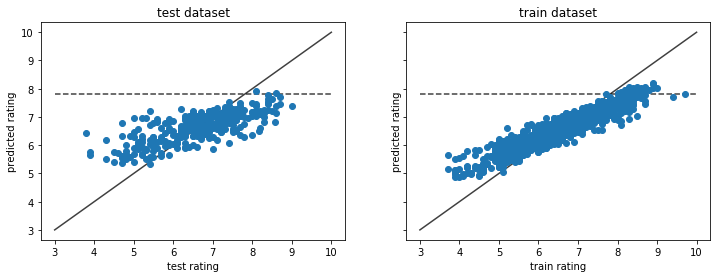

In [682]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
ax1.scatter(y_merged_test.rating, pred_rf)
plt.setp(ax1, xlabel='test rating', ylabel='predicted rating')
plt.title("RF")
ax1.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax1.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax2.scatter(y_merged_train.rating, pred_train_rf)
plt.setp(ax2, xlabel='train rating', ylabel='predicted rating')
ax2.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax2.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax1.title.set_text("test dataset"); ax2.title.set_text("train dataset")
plt.savefig('model_pred_rf.png')
plt.show()

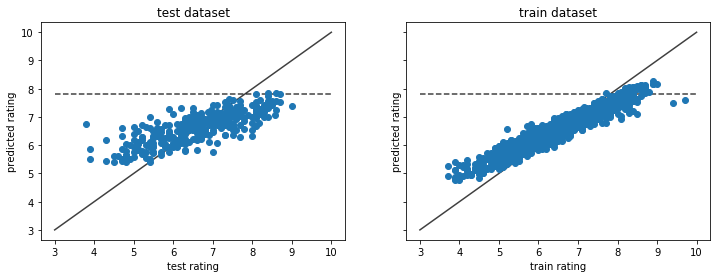

In [683]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
ax1.scatter(y_merged_test.rating, pred_et)
plt.setp(ax1, xlabel='test rating', ylabel='predicted rating')
plt.title("ET")
ax1.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax1.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax2.scatter(y_merged_train.rating, pred_train_et)
plt.setp(ax2, xlabel='train rating', ylabel='predicted rating')
ax2.plot([3,10], [3,10], 'k-', alpha=0.75, zorder=0)
ax2.plot([3,10], [7.8,7.8], 'k--', alpha=0.75, zorder=0)

ax1.title.set_text("test dataset"); ax2.title.set_text("train dataset")
plt.savefig('model_pred_et.png')
plt.show()

### Mixed Naive Bayes

In [90]:
# target values different from the code on shows dataset, as tensorflow input requires target to range from [0,2)
# so 0 represents the worst class and 2 represents the best here
y_merged_train_discretized = y_merged_train.copy()
y_merged_train_discretized['rating'] = y_merged_train_discretized.rating.apply(lambda x: 2 if x >= 7.8 else (1 if x >= 7.1 else 0))

y_merged_test_discretized = y_merged_test.copy()
y_merged_test_discretized['rating'] = y_merged_test_discretized.rating.apply(lambda x: 2 if x >= 7.8 else (1 if x >= 7.1 else 0))

In [91]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

gnb_c = GaussianNB()
mnb_c = MultinomialNB()
gnb_c.fit(np.concatenate((X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
                X_merged_train_transformed[['date', 'helpful_score']]), axis=1), 
                y_merged_train_discretized)
mnb_c.fit(hstack([X_train_genre_dtm2, X_train_pg_dtm2]).toarray(), y_merged_train_discretized)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [92]:
# get the probabilities
pred_proba_gnb_c = gnb_c.predict_proba(np.concatenate((X_test_reviewTFIDF_glv, X_test_rTitleTFIDF_glv, X_test_sypTFIDF_glv,
                X_merged_test_transformed[['date', 'helpful_score']]), axis=1))
pred_proba_train_gnb_c = gnb_c.predict_proba(np.concatenate((X_train_reviewTFIDF_glv, X_train_rTitleTFIDF_glv, X_train_sypTFIDF_glv,
                X_merged_train_transformed[['date', 'helpful_score']]), axis=1))

pred_proba_mnb_c = mnb_c.predict_proba(hstack([X_test_genre_dtm2, X_test_pg_dtm2]).toarray())
pred_proba_train_mnb_c = mnb_c.predict_proba(hstack([X_train_genre_dtm2, X_train_pg_dtm2]).toarray())

In [93]:
gnb_c.class_prior_

array([0.63501946, 0.21322957, 0.15175097])

In [94]:
prior_proba = gnb_c.class_prior_
pred_proba_nb_c = (pred_proba_gnb_c * pred_proba_mnb_c) / prior_proba
pred_proba_nb_c = (pred_proba_nb_c.T/ np.sum(pred_proba_nb_c, axis=1)).T
pred_nb_c = np.argmax(pred_proba_nb_c, axis=1)

pred_proba_train_nb_c = (pred_proba_train_gnb_c * pred_proba_train_mnb_c) / prior_proba
pred_proba_train_nb_c = (pred_proba_train_nb_c.T/ np.sum(pred_proba_train_nb_c, axis=1)).T
pred_train_nb_c = np.argmax(pred_proba_train_nb_c, axis=1)

In [95]:
print("overall accuracy for test: ", metrics.accuracy_score(y_merged_test_discretized.rating, pred_nb_c))
print("overall accuracy for train: ", metrics.accuracy_score(y_merged_train_discretized.rating, pred_train_nb_c))

overall accuracy for test:  0.5506329113924051
overall accuracy for train:  0.6186770428015564


In [96]:
print("confusion matrix for test: \n", metrics.confusion_matrix(y_merged_test_discretized.rating, pred_nb_c))
print("confusion matrix for train: \n", metrics.confusion_matrix(y_merged_train_discretized.rating, pred_train_nb_c))

confusion matrix for test: 
 [[121  43  39]
 [ 11  27  33]
 [  4  12  26]]
confusion matrix for train: 
 [[508 157 151]
 [ 41 145  88]
 [ 16  37 142]]
